In [1]:
import numpy as np
import porespy as ps
import matplotlib.pyplot as plt
import scipy.io as sio
import seaborn as sns
import skimage as ski
import tqdm
import scipy.stats

imageSize = 250

primaryImage = np.load('subBeadPackPy250_justSpheres.npy')
secondaryImage = np.load('finalSimFile3D250.npy')
primaryImage[primaryImage == 255] = 1

primaryImage = np.transpose(primaryImage)
secondaryImage = np.transpose(secondaryImage)

velSecondaryMat = sio.loadmat('velNormSecondary.mat')
velDataNormSecondary = velSecondaryMat['velNorm']

velPrimaryMat = sio.loadmat('velNormPrimary.mat')
velDataNormPrimary = velPrimaryMat['velNorm']

resolution = 16.81E-6 # adding resolution in meters

# Plot pore space and velocity

Plot the sample with secondary porosity

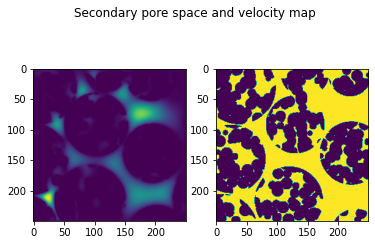

In [2]:
slice = 35

fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Secondary pore space and velocity map')
p1.imshow(velDataNormSecondary[:,:,slice])
p2.imshow(secondaryImage[:,:,slice])

fig.savefig('secondaryPoreImage.png')


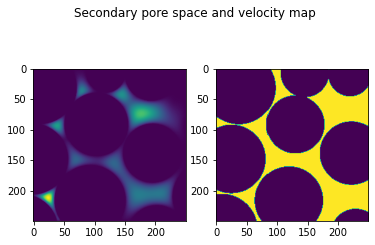

In [3]:
slice = 35

fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Secondary pore space and velocity map')
p1.imshow(velDataNormPrimary[:,:,slice])
p2.imshow(primaryImage[:,:,slice])

fig.savefig('primaryPoreImage.png')

# Extract pore network information

In [4]:
snowFiltSecondary = ps.filters.snow_partitioning(im=secondaryImage,r_max=4,sigma=0.4, return_all=True)
poreInfoSecondary = ps.networks.regions_to_network(snowFiltSecondary.regions, dt=snowFiltSecondary.dt)

nRegions = np.unique(snowFiltSecondary.regions).size
secondaryPoreDiamVec = np.zeros(nRegions,)

for a in range(0, poreInfoSecondary['pore.diameter'].size):
    secondaryPoreDiamVec[a] = poreInfoSecondary['pore.diameter'][a]

secondaryRegions = snowFiltSecondary.regions

------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  1436
Peaks after trimming saddle points:  938
Peaks after trimming nearby peaks:  922
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 922/922 [00:10<00:00, 91.22it/s] 


In [5]:
snowFiltPrimary = ps.filters.snow_partitioning(im=primaryImage,r_max=4,sigma=0.4, return_all=True)
poreInfoPrimary = ps.networks.regions_to_network(snowFiltPrimary.regions, dt=snowFiltPrimary.dt)

nRegions = np.unique(snowFiltSecondary.regions).size
primaryPoreDiamVec = np.zeros(nRegions,)

for a in range(0, poreInfoPrimary['pore.diameter'].size):
    primaryPoreDiamVec[a] = poreInfoPrimary['pore.diameter'][a]

primaryRegions = snowFiltPrimary.regions

------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  113
Peaks after trimming saddle points:  104
Peaks after trimming nearby peaks:  93
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 93/93 [00:05<00:00, 17.99it/s]


In [ ]:
ps.io.to_vtk(secondaryRegions,'snowRegionsSecondary')
ps.io.to_vtk(primaryRegions,'snowRegionsPrimary')

# Bin extracted pore diameter data for plotting

In [8]:
# Bin pore diameter data
#max(poreInfo['pore.diameter'])
#min(poreInfo['pore.diameter'])
n_bins = 100

primaryPoreBins = np.linspace(0.1,60,n_bins)
primaryPoreDiamVec = poreInfoPrimary['pore.diameter']
primaryBinnedInd = np.digitize(primaryPoreDiamVec, primaryPoreBins)

allKeys = np.round(primaryPoreBins,2)
primaryBinnedPoreDiam = dict.fromkeys(allKeys)

for i in primaryBinnedPoreDiam.keys():
    primaryBinnedPoreDiam[i] = []

# currently storing all of the diameters of a pore for a binned pore size
for i in range(1, len(primaryBinnedInd)):
    key=primaryPoreBins[primaryBinnedInd[i]]
    key = round(key,2)
    primaryBinnedPoreDiam[key].append(primaryPoreDiamVec[i])
    #binnedPoreDiam[key].append(poreDispVector[i])

#regionLabel[i].append
secondaryPoreBins = np.linspace(0.1,60,n_bins)
secondaryPoreDiamVec = poreInfoSecondary['pore.diameter']
secondaryBinnedInd = np.digitize(secondaryPoreDiamVec, secondaryPoreBins)

allKeys = np.round(secondaryPoreBins,2)
secondaryBinnedPoreDiam = dict.fromkeys(allKeys)

for i in secondaryBinnedPoreDiam.keys():
    secondaryBinnedPoreDiam[i] = []

# currently storing all of the diameters of a pore for a binned pore size
for i in range(1, len(secondaryBinnedInd)):
    key=secondaryPoreBins[secondaryBinnedInd[i]]
    key = round(key,2)
    secondaryBinnedPoreDiam[key].append(secondaryPoreDiamVec[i])
    #binnedPoreDiam[key].append(poreDispVector[i])
#regionLabel[i].append


# Plot distribution of pore diameter

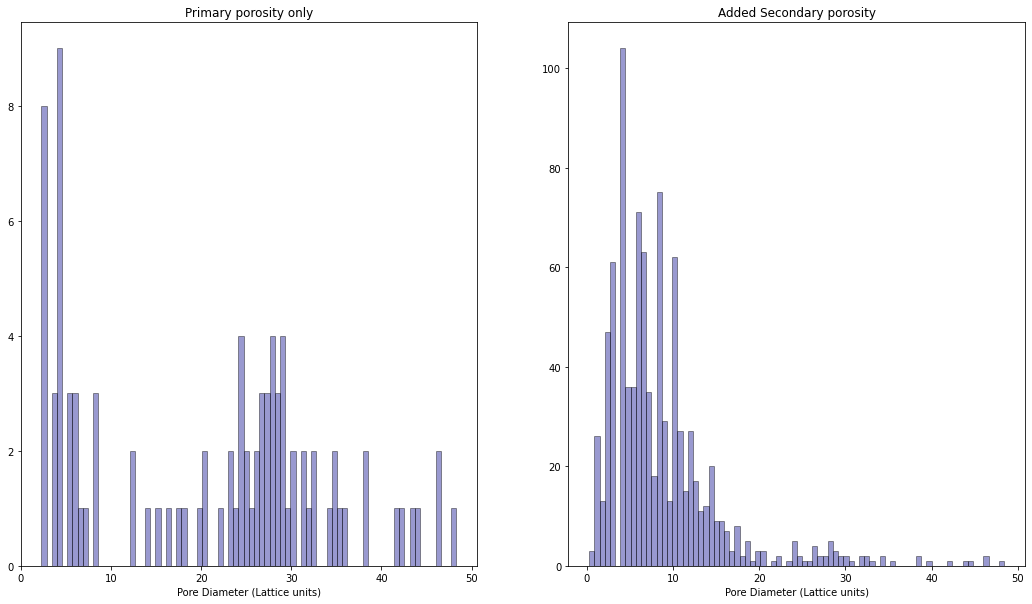

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
sns.distplot(primaryPoreDiamVec, ax=axes[0], hist=True, kde=False,
             bins=int(80), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
axes[0].set_title('Primary porosity only')
axes[0].set_xlabel('Pore Diameter (Lattice units)')

sns.distplot(secondaryPoreDiamVec, ax=axes[1], hist=True, kde=False,
             bins=int(80), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
axes[1].set_title('Added Secondary porosity')
axes[1].set_xlabel('Pore Diameter (Lattice units)')

fig.savefig('poreDiamHist.png')

### I will say pore diameter > 20 units are "big pores"

# Skeleton implementation

In [10]:
secondaryRegionData = ps.metrics.regionprops_3D(snowFiltSecondary.regions) #Gives properties for each region
#primaryRegionData = ps.metrics.regionprops_3D(snowFiltPrimary.regions)

100%|██████████| 922/922 [01:10<00:00, 13.04it/s]


------------------------------------------------------------
Calculating regionprops


Find skeleton for secondary image and collect info

In [11]:
len(np.unique(secondaryRegions))

923

In [13]:
# Skeleton for all pores
cubeSize = len(secondaryImage)
visit = np.zeros(len(np.unique(secondaryRegions)))
secondaryPoreDiamImage = np.zeros(secondaryImage.shape)
allSecondaryRegions = np.unique(secondaryRegions)
tempImage = np.zeros(secondaryRegions.shape)
secondaryPoreDiamVectorSkeleton = np.zeros(len(allSecondaryRegions))

secondarySkelImage = ski.morphology.skeletonize(secondaryImage)

for a in tqdm.tqdm(range(0,len(allSecondaryRegions)), 'Main loop'):
            regionLabel = a
            if regionLabel != 0: # Don't want grains to be counted
                if visit[regionLabel] == 0:
                    visit[regionLabel] = 1
                    # Adjust indices for pore information, regionlabel = 0 is pore 1 in poreInfo
                    poreDiam = secondaryPoreDiamVec[regionLabel - 1]
                    secondaryPoreDiamImage[secondaryRegions == regionLabel] = poreDiam




Main loop: 100%|██████████| 923/923 [00:15<00:00, 59.29it/s]


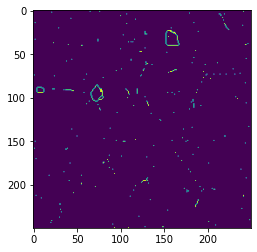

In [28]:
#secondarySkelImage[secondaryImage == 0] = 0
ps.io.to_vtk(secondarySkelImage,'secondarySkeletonWholeImage')
plt.imshow(secondarySkelImage[:,:,40])

secondaryImageOut = np.copy(secondaryImage)
secondaryImageOut = secondaryImageOut.astype(int)
secondaryImageOut[secondaryImage == 1] = 255
ps.io.to_vtk(secondaryImageOut,'secondaryImage')
secondaryImageOut[primaryImage == 255] = 1

# Now plot velocitites on skeleton and extract information

In [14]:
secondaryVelocitiesSkeleton = []
secondaryPoreDiamSkeleton = []
secondaryPoreRegionSkeleton = []

for a in tqdm.tqdm(range(0,cubeSize), 'Main loop'):
    for b in range(0,cubeSize):
        for c in range(0, cubeSize):
            # If the primary skeleton image is not zero, then save the velocity data
            # The primary skeleton image will be zero for all indices except the skeleton found above which
            # should be the values in the middle of all of the pores, no pore walls etc...
            # This array should contain the velocity data we want to use to define flow/no flow etc...
            if secondarySkelImage[a,b,c] != 0:
                secondaryVelocitiesSkeleton = np.append(secondaryVelocitiesSkeleton,velDataNormSecondary[a,b,c])
                secondaryPoreDiamSkeleton = np.append(secondaryPoreDiamSkeleton, secondaryPoreDiamImage[a,b,c])
                secondaryPoreRegionSkeleton = np.append(secondaryPoreRegionSkeleton, secondaryRegions[a,b,c])

Main loop: 100%|██████████| 250/250 [00:42<00:00,  5.95it/s]


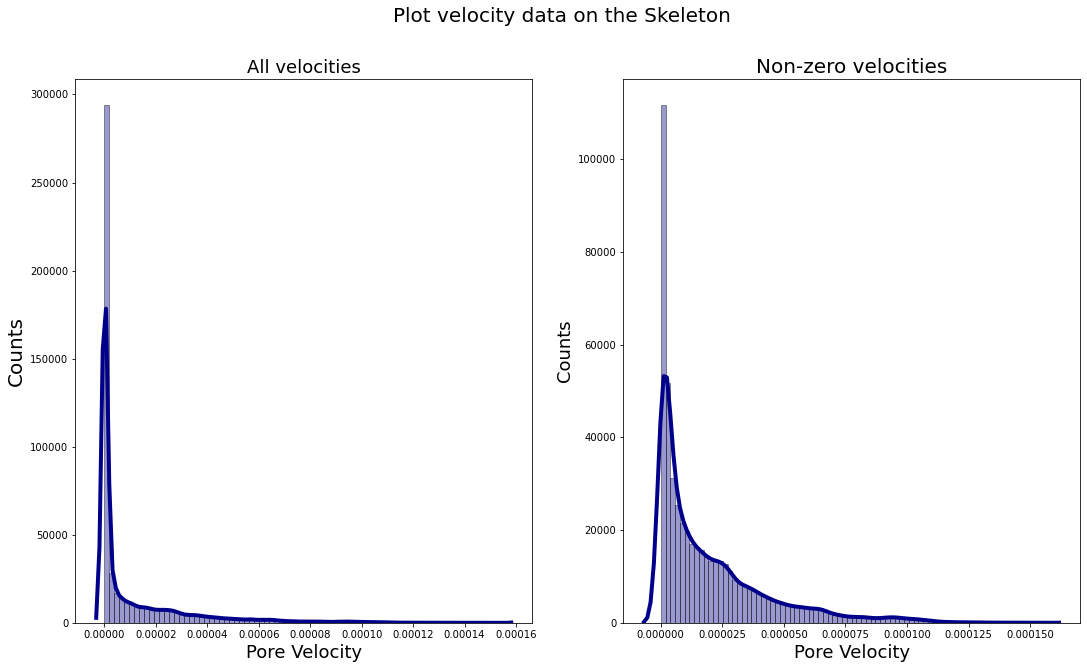

In [30]:
# The zeros seen here are truly no flow I think, they aren't pore walls and this is after the flow simulation, so
# even though the initial lattice state is v = 0, these are still zero

fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle('Plot velocity data on the Skeleton', fontsize=20)

sns.distplot(secondaryVelocitiesSkeleton, ax=axes[0], hist=True, kde=True,
             bins=int(80), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
axes[0].set_title('All velocities', fontsize=18)
axes[0].set_xlabel('Pore Velocity', fontsize=18)
axes[0].set_ylabel('Counts', fontsize=20)

sns.distplot(secondaryVelocitiesSkeleton[secondaryVelocitiesSkeleton != 0], ax=axes[1], hist=True, kde=True,
             bins=int(80), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
axes[1].set_title('Non-zero velocities', fontsize=20)
axes[1].set_xlabel('Pore Velocity', fontsize=18)
axes[1].set_ylabel('Counts', fontsize=18)

fig.savefig('poreVelHistograms.png')

# Plot pore velocities with pore diameters

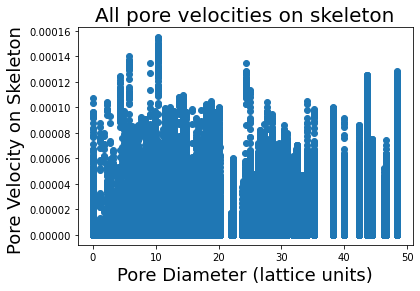

In [15]:
plt.scatter(secondaryPoreDiamSkeleton, secondaryVelocitiesSkeleton)
plt.xlabel('Pore Diameter (lattice units)', fontsize=18)
plt.ylabel('Pore Velocity on Skeleton ', fontsize=18)
plt.title('All pore velocities on skeleton', fontsize=20)

fig.savefig('allPoreVelocities.png')


Try taking computing a representative velocity threshold (use interquartile range)

In [26]:


IQR_PoreVelocity =  []
meanPoreVelocity =  []
skeletonPoreDiam = []
skeletonPoreRegion = []
poreRegions, indices = np.unique(secondaryPoreRegionSkeleton, return_index='True')

for a in tqdm.tqdm(range(0, len(allSecondaryRegions)), 'Main Loop'):
    currentRegion = a
    if currentRegion != 0:
        skeletonPoreVel = secondaryVelocitiesSkeleton[secondaryPoreRegionSkeleton == currentRegion]
        meanPoreVelocity = np.append(meanPoreVelocity, np.mean(skeletonPoreVel))
        IQR_PoreVelocity = np.append(IQR_PoreVelocity, scipy.stats.iqr(skeletonPoreVel, interpolation = 'midpoint'))

        # Adjust indices between regionProps and snow algorithm
        skeletonPoreDiam = np.append(skeletonPoreDiam, poreInfoSecondary['pore.diameter'][currentRegion-1] )

        skeletonPoreRegion = np.append(skeletonPoreRegion, currentRegion)

Main Loop: 100%|██████████| 923/923 [00:00<00:00, 4249.96it/s]


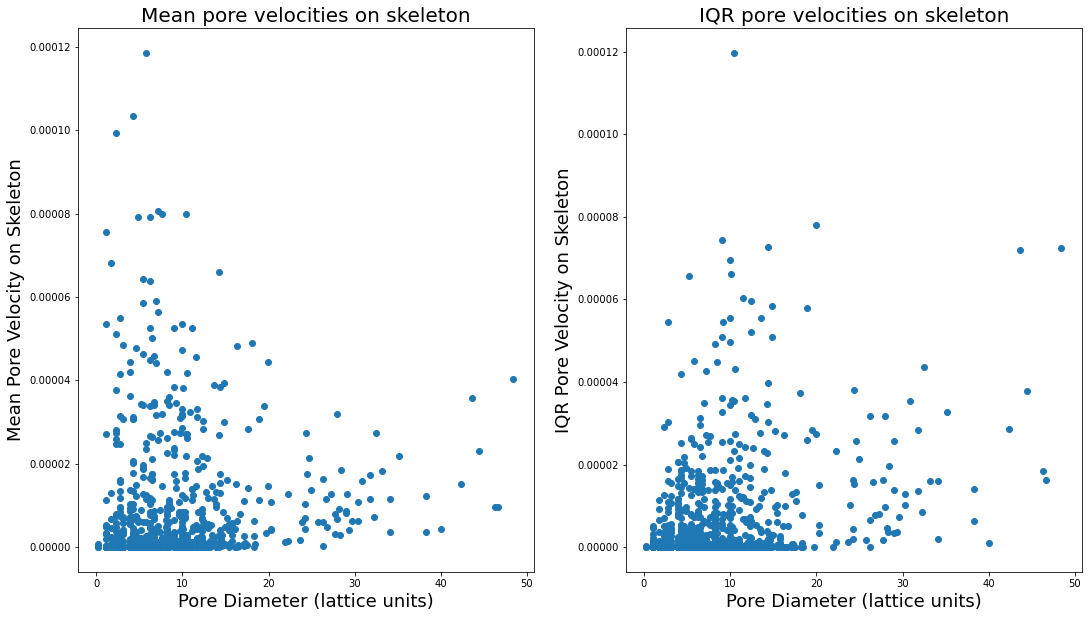

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
axes[0].scatter(skeletonPoreDiam, meanPoreVelocity)
axes[0].set_xlabel('Pore Diameter (lattice units)', fontsize=18)
axes[0].set_ylabel('Mean Pore Velocity on Skeleton', fontsize=18)
axes[0].set_title('Mean pore velocities on skeleton', fontsize=20)

axes[1].scatter(skeletonPoreDiam, IQR_PoreVelocity)
axes[1].set_xlabel('Pore Diameter (lattice units)', fontsize=18)
axes[1].set_ylabel('IQR Pore Velocity on Skeleton', fontsize=18)
axes[1].set_title('IQR pore velocities on skeleton', fontsize=20)

fig.savefig('poreVelAveraging.png')

Separate all pores with low velocity


In [28]:
# Best choice for this? hardcoded to 0 per discussion on 4/2
noFlowVelCutoff = 0 # 0.5 * 10 ** float(-5)
print(noFlowVelCutoff)

0


In [29]:
poreRegions, indices = np.unique(secondaryPoreRegionSkeleton, return_index='True')
noFlowRegions = skeletonPoreRegion[IQR_PoreVelocity == 0]
noFlowImage = np.zeros(secondaryImage.shape)
flowImage = np.copy(secondaryImage)
noFlowRegionVector = []

for a in tqdm.tqdm(range(0,len(noFlowRegions)), 'Main loop'):
    regionInd = noFlowRegions[a]
    noFlowRegionVector = np.append(noFlowRegionVector, regionInd)
    #print('This is a no flow region:', regionInd)
    noFlowImage[secondaryRegions == regionInd] =  1
    flowImage[secondaryRegions == regionInd] = 0



Main loop: 100%|██████████| 290/290 [00:09<00:00, 30.37it/s]


### Select pores with large pore sizes

In [ ]:
# Rescale no Flow data
velImage = velDataNormSecondary
velImage = velImage / np.max(velImage)
velImage = velImage * 200
ps.io.to_vtk(velImage,'secondaryVelocityImage')

noFlowOut = noFlowImage
noFlowOut[noFlowImage == 1] = 255
ps.io.to_vtk(noFlowImage,'noFlowSecondaryRegionImage')

# Compute estimate of mobile porosity

Total Porosity

In [30]:
porosityCalc = ps.metrics.porosity(secondaryImage)
print('Total porosity:')
print(porosityCalc)

Total porosity:
0.545888832


Estimate of mobile porosity

In [31]:
# Get grains
flippedImage = np.copy(secondaryImage)
flippedImage[secondaryImage == 1] = 0
flippedImage[secondaryImage == 0] = 1
porosityCalc = ps.metrics.porosity(secondaryImage)

sumPorosity = np.sum(secondaryImage)/(np.sum(flippedImage)+np.sum(secondaryImage))
print(sumPorosity)

mobileOnes = np.sum(flowImage)
total = np.sum(flippedImage) + np.sum(flowImage) + np.sum(noFlowImage)
mobilePorosity = mobileOnes/total
print('Mobile porosity estimate:')
print(mobilePorosity)
print('Mobile fraction of porosity')
mobileFrac = (mobilePorosity/porosityCalc)
print(mobileFrac)

0.545888832
Mobile porosity estimate:
0.487801728
Mobile fraction of porosity
0.8935916974392324


In [ ]:
dispIM = np.copy(secondaryImage)
dispIM[secondaryImage == 1] = 255
#dispIM[secondaryImage == 1] = 0
totalPorosityImage = ps.visualization.show_3D(dispIM)
plt.imshow(totalPorosityImage)

plt.savefig('allPoreImage.png')

In [ ]:
dispIM = np.copy(flowImage)
dispIM[flowImage == 0] = 255
dispIM[flowImage == 1] = 0
dispFlowImage = ps.visualization.show_3D(dispIM)
plt.imshow(dispFlowImage)

plt.savefig('flowImage.png')
